# Extracting features from text file


See https://towardsdatascience.com/document-feature-extraction-and-classification-53f0e813d2d3

In [1]:
import spacy
import textacy

import numpy as np
from sklearn.feature_extraction import text
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
content = """That dirty tricks exist in the world of high-stakes politics will come as a surprise to few. Nonetheless, leaders of the global firm Cambridge Analytica captured headlines around the world this week as they breezily discussed the strategies for deception and manipulation of foreign elections on hidden cameras. Cambridge Analytica has been accused of improperly using information from more than 50 million Facebook accounts. The London-based company denies wrongdoing. Cambridge Analytica is best known for its work with Donald Trump's presidential election campaign in 2016. CEO Alexander Nix, unaware he was being recorded, claimed he'd met Trump "many times" in a bombshell undercover investigation broadcast Tuesday on Britain's Channel 4 news. A colleague also suggested they created damaging memes targeting Hillary Clinton during the election. Nix was suspended the day after the story aired. The investigation revealed that over the course of four meetings, the journalists used hidden cameras and microphones to record Nix and the company's managing director Mark Turnbull, as they discussed ways to secretly influence Sri Lanka's upcoming national election — something they claim they'd already done in Kenya in 2017."""

print(content)

In [ ]:
metadata = {'title': 'How Cambridge Analytica stumbled into the spotlight',
            'author': 'Diana Swain',
            'pub_date': '2018-03-24'}

## 1. Using spaCy and textaCy

In [ ]:
doc = textacy.Doc(content, metadata=metadata, lang='en')
print(doc)

In [ ]:
doc.to_bag_of_terms(ngrams=2, named_entities=False, lemmatize=True, 
                    as_strings=True)

In [ ]:
[i for i in textacy.extract.named_entities(doc)]

## 2. Using sklearn

In [ ]:
# Load example dataset
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']

from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [16]:
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE


TSNE_ARGS = {'n_components': 2, 
             'verbose': 1, 
             'random_state':0, 
             'angle':.99,
             'init': 'pca'}


def fit_tsne_on_corpus(corpus, labels=None, tsne_args=TSNE_ARGS):
    """Fit t-SNE on a text corpus.
    
    Fit t-SNE on a text corpus.
    The following steps are used:
    1. Extract word count from each document of the corpus.
    2. Transform word counts into tf-idf feature vectors.
    3. (Optional) Add labels to the matrix.
    4. Run t-SNE.
    
    Args:
        corpus (list of str): list containing `n_docs` strings, where each 
            string is one document
    
    Keyword Args:
        labels (np.ndarray): labels to include when running t-SNE. Provided as
            array of shape (n_docs, n_labels) where each row contains the 
            labels for a specific document. Labels must be numerical values.  
        tsne_args (dict): dictionary of arguments to pass to sklearn's
            TSNE function.
        
    Returns:
        (np.ndarray): array of shape (n_docs, 2) containing the t-SNE 
            coordinates for each document
            
    TODO:
    - Extract better features than tf-idf
    - Allow modifying t-SNE's hyperparameters
    - Use different t-SNE backend for speed
    """
    
    assert isinstance(corpus, list)

    count_vect = text.CountVectorizer()
    counts = count_vect.fit_transform(corpus)
    
    tfidf_transformer = text.TfidfTransformer()
    tfidf_data = tfidf_transformer.fit_transform(counts).todense()
    
    if labels is not None:
        tfidf_data = np.concatenate([tfidf_data, labels], axis=1)

    tsne_model = TSNE(**tsne_args)
    tsne_coords = tsne_model.fit_transform(tfidf_data)
    
    return tsne_coords


def plot_coords(coords, labels=None):
    """Plot coordinates with optional labels.
    
    Args:
        coords (np.ndarray): array of shape (n_points, 2) containing the
            coordinates of each point.
            
    Keyword Args:
        labels (np.ndarray): array of shape (n_points,) containing a categorical
            label or each point.
    """
    
    if labels is None:
        labels = np.zeros((coords.shape[0], ))
                
    classes = np.unique(labels)
    cm = sns.color_palette('hls', len(classes))
    
    fig, ax = plt.subplots()
    
    for i, c in enumerate(classes):
        print('Class {}'.format(c))
        ind = labels == c
        ax.scatter(coords[ind, 0], coords[ind, 1], s=5, 
                   color=cm[i], label=c)
    ax.legend()
        
    plt.show()

In [ ]:
fake_labels = np.zeros((50, 1))
fake_labels[25:, 0] = 1

coords = fit_tsne_on_corpus(twenty_train.data[:50], labels=fake_labels)

In [ ]:
plot_coords(coords, labels=fake_labels.reshape(-1,))

## Same functions, but using textacy

In [ ]:
# Load example dataset
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']

from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [10]:
from sklearn.manifold import TSNE


VECT_ARGS = {'apply_idf': True, 
             'norm': None, 
             'idf_type': 'smooth', 
             'min_df': 1,
             'max_df': 0.95, 
             'max_n_terms': 100000}

TSNE_ARGS = {'n_components': 2, 
             'verbose': 1, 
             'random_state':0, 
             'angle':.99,
             'init': 'pca'}


def fit_tsne_on_corpus2(corpus, labels=None, vect_args=VECT_ARGS,
                        tsne_args=TSNE_ARGS):
    """Fit t-SNE on a text corpus.
    
    Fit t-SNE on a text corpus.
    The following steps are used:
    1. Extract word count from each document of the corpus.
    2. Transform word counts into tf-idf feature vectors.
    3. (Optional) Add labels to the matrix.
    4. Run t-SNE.
    
    Args:
        corpus (textacy.Corpus): object containing the documents processed
            by textacy
        
    Keyword Args:
        labels (np.ndarray): labels to include when running t-SNE. Provided as
            array of shape (n_docs, n_labels) where each row contains the 
            labels for a specific document. Labels must be numerical values.  
        vect_args (dict): dictionary of arguments to pass to 
            textacy.vsm.Vectorizer().
        tsne_args (dict): dictionary of arguments to pass to sklearn's
            TSNE function.
        
    Returns:
        (np.ndarray): array of shape (n_docs, 2) containing the t-SNE 
            coordinates for each document
        (np.ndarray): array of shape (n_docs, n_features) containing the
            extracted features
            
    TODO:
    - Extract better features than tf-idf
    - Allow modifying t-SNE's hyperparameters
    - Use different t-SNE backend for speed
    """
        
    terms_list = (doc.to_terms_list(ngrams=1, named_entities=True,
                                    as_strings=True) 
                  for doc in corpus)
    
    vectorizer = textacy.vsm.Vectorizer(**vect_args)
    term_matrix = vectorizer.fit_transform(terms_list).todense()
        
    if labels is not None:
        term_matrix = np.concatenate([term_matrix, labels], axis=1)
        
    tsne_model = TSNE(**tsne_args)
    tsne_coords = tsne_model.fit_transform(term_matrix)
    
    return tsne_coords, term_matrix

In [ ]:
%%time
corpus = textacy.Corpus(lang='en', texts=twenty_train.data[:50])

In [ ]:
fake_labels = np.zeros((50, 1))
fake_labels[25:, 0] = 100

In [ ]:
coords, feats = fit_tsne_on_corpus2(corpus, labels=fake_labels)

In [ ]:
plot_coords(coords, labels=fake_labels.reshape(-1,))

## Trying with our data!

Olivier collected data using the Alyen News API. Let's load it and see what kind of map we get!

In [3]:
import glob
import os
import codecs
import json 

from joblib import Parallel, delayed


folderpath = '/home/hubert/Documents/kesseca/data/outlets_27'
filepaths = glob.glob(os.path.join(folderpath, '*.json'))

In [5]:
# Political spectrum labels
political_labels = {"abc-news": 3,
                    "al-jazeera-english": 3,
                    "associated-press": 3,
                    "axios": 3,
                    "bbc-news": 3,
                    "bloomberg": 3,
                    "breitbart-news": 5,
                    "business-insider": 3,
                    "cnbc": 3,
                    "cnn": 3,
                    "fox-news": 4,
                    "msnbc": 1,
                    "nbc-news": 3,
                    "newsweek": 2,
                    "new-york-magazine": 1,
                    "politico": 2,
                    "reuters": 3,
                    "the-economist": 2,
                    "the-guardian-uk": 2,
                    "the-hill": 3,
                    "the-new-york-times": 2,
                    "the-huffington-post": 2,
                    "the-telegraph": 4,
                    "the-wall-street-journal": 3,
                    "the-washington-post": 2,
                    "time": 1,
                    "usa-today": 3,
                    "vice-news": 1,
                    "cbs-news": 3,
                    "google-news": 3}

In [5]:
# Load the JSON files
data = []

for path in filepaths:
    with codecs.open(path, 'r', encoding='utf8') as f:  # , 
        data.append(json.load(f))

Let's start by making a t-SNE map from the articles of the first outlet.

In [6]:
def convert_str_to_doc_parallel(data, n_jobs=4):
    """
    Args:
        data (list of str): 
    """
    docs = Parallel(n_jobs=n_jobs)(
        delayed(textacy.Doc)(content=article['body'], lang='en',
                             metadata={'title': article['title'],
                                       'date': article['date']})
                             for article in data)
    
    return docs

In [7]:
%%time
outlets = data[4]['articles']['results'][:15] + data[21]['articles']['results'][:15]
docs = convert_str_to_doc_parallel(outlets)

CPU times: user 10 s, sys: 558 ms, total: 10.6 s
Wall time: 23 s


In [8]:
corpus = textacy.Corpus(lang='en', docs=docs)

ValueError: Doc.spacy_vocab <spacy.vocab.Vocab object at 0x7f343458ee48> != Corpus.spacy_vocab <spacy.vocab.Vocab object at 0x7f343458ebc8>

In [24]:
tsne_args = {'n_components': 2, 
             'perplexity': 100,
             'learning_rate': 10,
             'verbose': 1, 
             'random_state':0, 
             'angle': 0.5,
             'init': 'random',
             'n_iter': 5000}

coords, feats = fit_tsne_on_corpus2(docs, labels=None, 
                                    tsne_args=tsne_args)

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 30.876721
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.310295
[t-SNE] Error after 800 iterations: 0.110490


Class 0.0


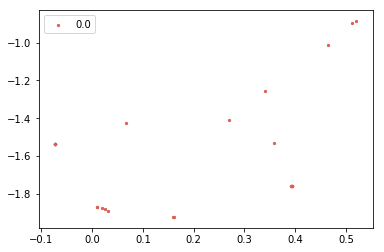

In [25]:
plot_coords(coords)  #, labels=fake_labels.reshape(-1,))

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(feats, vmax=20)